<a href="https://colab.research.google.com/github/jarraomar/AITDeepLearning/blob/main/Copy_of_AIT_09_Author_classification_assessment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Copyright

<PRE>
Copyright (c) 2023 Bálint Gyires-Tóth - All Rights Reserved
You may use and modify this code for research and development purpuses.
Use this code for educational purposes (self-paced or instructor led) without the permission of the author is prohibited.
</PRE>

# Author classification
The task is to train a 1D CNN or an LSTM that is able to  classify text from two authors. The final model should be able to tell about a text with a given length (e.g. 60 characters) who wrote it. 

Please write the codes according to the following parts:

## Python module imports
Import all Python modules that you would need during the Assignment.

In [113]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Activation, Dense, Flatten, Conv1D, MaxPooling1D, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow.keras.utils as ku
import matplotlib.pyplot as plt
import seaborn as sns

## Data acquisition
Seek a possible dataset, you can use any source, e.g.
* http://www.gutenberg.org/
* https://www.kaggle.com/datasets
* https://paperswithcode.com/datasets
* if you would like to learn Hungarian, than e.g. https://mek.oszk.hu/

You can download the text by hand (e.g. by copy-pasting some parts into txt files) or with Python. 

In [114]:
from google.colab import drive
import pandas as pd
drive.mount('/content/drive')

train_data = pd.read_csv('/content/drive/MyDrive/data/train.csv')
test_data = pd.read_csv('/content/drive/MyDrive/data/test.csv')
sample_submission = pd.read_csv('/content/drive/MyDrive/data/sample_submission.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Data analysis
Count the number of characters from both authors and display them on a plot (e.g. Seaborn's countplot).

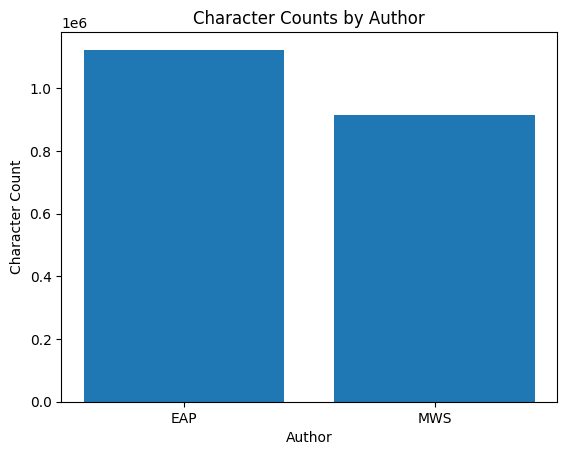

In [133]:
train_eap = sum(train_data[train_data['author'] == 'EAP']['text'].str.len())
train_mws = sum(train_data[train_data['author'] == 'MWS']['text'].str.len())


authors = ['EAP', 'MWS']
character_counts = [train_eap, train_mws]
fig, ax = plt.subplots()
ax.bar(authors, character_counts)
ax.set_xlabel('Author')
ax.set_ylabel('Character Count')
ax.set_title('Character Counts by Author')
plt.show()

## Data loading, labeling and preprocessing
Load the data and convert the characters into one-hot encodings. Then load the data into a 3D NumPy array, with a shape of

* (batch, sequence_length, alphabet_length)

where sequence_length=60, and alphabet_length equals to the number of unique characters in both datasets. The sequences should be cut out from the complete dataset by sliding window. You should add 0 and 1 labels to the sequences, according to the author. 

Later you may change sequence_length to achieve better results!

In [126]:
# Was able to figure out how to load, label, and preprocess through the help of 
# chatgpt

combined_data = pd.concat([train_data, test_data])
unique_chars = sorted(set(''.join(combined_data['text'].values)))
char_to_index = dict((c, i) for i, c in enumerate(unique_chars))
max_seq_length = 60

def text_to_one_hot(text, max_seq_length, char_to_index):
    sequence = [char_to_index[c] for c in text if c in char_to_index]
    sequence = sequence[:max_seq_length] + [0] * (max_seq_length - len(sequence))
    one_hot = ku.to_categorical(sequence, num_classes=len(char_to_index))
    return one_hot

def generate_dataset(data, max_seq_length, char_to_index):
    sequences = []
    labels = []
    if 'author' in data.columns:
        for i, row in data.iterrows():
            text = row['text']
            author = row['author']
            sequence = text_to_one_hot(text, max_seq_length, char_to_index)
            sequences.append(sequence)
            if author == 'EAP':
                label = [1, 0]
            elif author == 'MWS':
                label = [0, 1]
            labels.append(label)
    else:
        for i, row in data.iterrows():
            text = row['text']
            sequence = text_to_one_hot(text, max_seq_length, char_to_index)
            sequences.append(sequence)
            labels.append([0, 0])
    return np.array(sequences), np.array(labels)


train_sequences, train_labels = generate_dataset(train_data, max_seq_length, char_to_index)
test_sequences, test_labels = generate_dataset(test_data, max_seq_length, char_to_index)

## Data splitting
Split the data into train, validate and test sets. Make 

In [127]:
train_sequences, val_sequences, train_labels, val_labels = train_test_split(
    train_sequences, train_labels, test_size=0.2, random_state=42)

## Model definition
Define a 1D CNN or an LSTM for the task. Compile the model with the correct loss function.

In [128]:
model = Sequential()
model.add(Conv1D(128, 5, activation='relu', input_shape=train_sequences.shape[1:]))
model.add(MaxPooling1D(pool_size=4))
model.add(Conv1D(64, 5, activation='relu'))
model.add(MaxPooling1D(pool_size=4))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_12 (Conv1D)          (None, 56, 128)           55808     
                                                                 
 max_pooling1d_12 (MaxPoolin  (None, 14, 128)          0         
 g1D)                                                            
                                                                 
 conv1d_13 (Conv1D)          (None, 10, 64)            41024     
                                                                 
 max_pooling1d_13 (MaxPoolin  (None, 2, 64)            0         
 g1D)                                                            
                                                                 
 flatten_6 (Flatten)         (None, 128)               0         
                                                                 
 dense_12 (Dense)            (None, 64)               

## Model training
Train the model and apply early stopping.

In [129]:
es = EarlyStopping(patience=5, restore_best_weights=True, monitor="val_loss")
model.fit(train_sequences, train_labels, 
          epochs=50, batch_size=32, 
          validation_split=0.2,
          callbacks=[es],
          verbose=2)

Epoch 1/50
392/392 - 10s - loss: 0.6858 - accuracy: 0.5611 - val_loss: 0.6783 - val_accuracy: 0.5729 - 10s/epoch - 26ms/step
Epoch 2/50
392/392 - 7s - loss: 0.6743 - accuracy: 0.5709 - val_loss: 0.6638 - val_accuracy: 0.5892 - 7s/epoch - 19ms/step
Epoch 3/50
392/392 - 9s - loss: 0.6431 - accuracy: 0.6221 - val_loss: 0.6577 - val_accuracy: 0.6144 - 9s/epoch - 22ms/step
Epoch 4/50
392/392 - 7s - loss: 0.5833 - accuracy: 0.6967 - val_loss: 0.6452 - val_accuracy: 0.6444 - 7s/epoch - 18ms/step
Epoch 5/50
392/392 - 9s - loss: 0.5119 - accuracy: 0.7514 - val_loss: 0.6717 - val_accuracy: 0.6492 - 9s/epoch - 23ms/step
Epoch 6/50
392/392 - 8s - loss: 0.4293 - accuracy: 0.8050 - val_loss: 0.7247 - val_accuracy: 0.6230 - 8s/epoch - 21ms/step
Epoch 7/50
392/392 - 8s - loss: 0.3487 - accuracy: 0.8537 - val_loss: 0.7774 - val_accuracy: 0.6132 - 8s/epoch - 21ms/step
Epoch 8/50
392/392 - 9s - loss: 0.2867 - accuracy: 0.8851 - val_loss: 1.0067 - val_accuracy: 0.6237 - 9s/epoch - 23ms/step
Epoch 9/50
392

## Evaluation on test data
Evaluate the model on the test data in terms of loss and accuracy.

In [130]:
eval = model.evaluate(test_sequences,test_labels)
print("Test loss:",eval[0])
print("Test accuracy:",eval[1])

263/263 [==============================] - 3s 11ms/step - loss: 0.0000e+00 - accuracy: 0.7048
Test loss: 0.0
Test accuracy: 0.7048379182815552


## Confusion matrix
Calculate and display the confusion matrix.

263/263 [==============================] - 2s 7ms/step
              precision    recall  f1-score   support

           0       1.00      0.70      0.83      8392
           1       0.00      1.00      0.00         0

    accuracy                           0.70      8392
   macro avg       0.50      0.85      0.41      8392
weighted avg       1.00      0.70      0.83      8392



<Axes: >

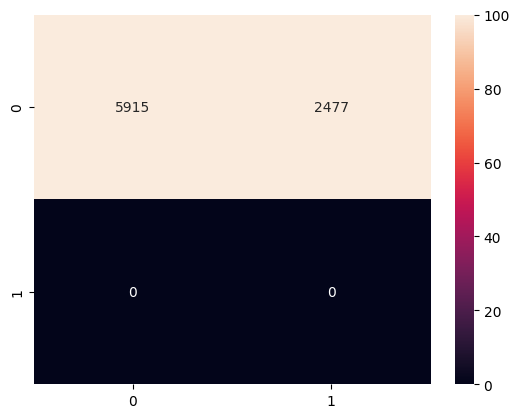

In [135]:
preds = model.predict(test_sequences)
print(classification_report(np.argmax(test_labels,1),np.argmax(preds,1), zero_division=1))

conf=confusion_matrix(np.argmax(test_labels,1),np.argmax(preds,1))
sns.heatmap(conf, annot=True, fmt='d', vmax=100)